In [1]:
import os
import sys
from functools import reduce
import datetime
import pprint

import numpy as np


import matplotlib.pyplot as plt
import tensorflow as tf

sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, C, V
from seismicpro.batchflow.named_expr import eval_expr

from seismicpro.src import SeismicDataset, FieldIndex, TraceIndex, SeismicBatch
from seismicpro.models import attention_loss, FieldMetrics, UnetAtt
from seismicpro.models.unetatt_3 import UnetAttention4, UnetAttention3

from seismicpro.batchflow.research import Research, Option, KV


%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


In [2]:
def exp_stack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data(batch, **kwagrs):
    return {'trace_raw': exp_stack(batch.raw),
                          'offset': np.vstack(batch.trace_headers('offset')),
                          'lift': exp_stack(batch.lift)}
def make_dataset(base_path, paths, idx_range):
    field_index = reduce(lambda x, y: x.merge(y), 
                     (FieldIndex(name=name, path=os.path.join(base_path,path), extra_headers=['offset']) for name, path in paths.items()))
    fi = field_index.indices[idx_range]   
    tindex = TraceIndex(field_index.create_subset(fi))
    return SeismicDataset(tindex), fi


In [3]:
raw_shape = (3000, 1)
offset_shape = (1,)


common_config = {
    'initial_block/inputs': ['trace_raw', 'offset'],
    'inputs': dict(trace_raw={'shape': raw_shape},
                   offset={'shape': offset_shape},
                   lift={'name': 'targets', 'shape': raw_shape}),

    'loss': (attention_loss, {'balance': 0.05}),
    'optimizer': ('Adam', {'learning_rate': 0.001}),
    'common/data_format': 'channels_last',
}

unetatt_new_config ={
    'body/encoder': {'num_stages': 4,
                     'blocks': dict(layout='caca', filters=[16, 32, 64, 128], kernel_size=7, activation=tf.nn.elu),
                     'downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05)},
    'body/embedding': dict(layout='caca', filters=256, kernel_size=7, activation=tf.nn.elu),
    'body/decoder': {'blocks': dict(layout='caca', filters=[128, 64, 32, 16], kernel_size=7, activation=tf.nn.elu),
                     'upsample': dict(layout='tad', kernel_size=7, strides=2, dropout_rate=0.05, activation=tf.nn.elu)},
    'body/attention': {'blocks': dict(layout='caca', filters=[64, 32, 16, 8], kernel_size=3, activation=tf.nn.elu),
                       'upsample': dict(layout='tad', kernel_size=3, strides=2,
                                        dropout_rate=0.05, activation=tf.nn.elu)},
}

unetatt_old_config = {
    'body': {'main': {
        'encoder/num_stages': 5,
        'encoder/blocks': dict(layout='caca', filters=[16, 32, 64, 128, 256], kernel_size=7, activation=tf.nn.elu),
        'encoder/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),

        'decoder/num_stages': 5,
        'decoder/blocks': dict(layout='caca', filters=[16, 32, 64, 128, 256][::-1], kernel_size=7,
                               activation=tf.nn.elu),
        'decoder/upsample': dict(layout='tad', kernel_size=7, strides=2,
                                 dropout_rate=0.05, activation=tf.nn.elu, ),
    },
        'attn': {
            'encoder/num_stages': 4,
            'encoder/blocks': dict(layout='caca', filters=[8, 16, 32, 64], kernel_size=3, activation=tf.nn.elu),
            'encoder/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),

            'decoder/num_stages': 4,
            'decoder/blocks': dict(layout='caca', filters=[8, 16, 32, 64][::-1], kernel_size=3, activation=tf.nn.elu),
            'decoder/upsample': dict(layout='tad', kernel_size=3, strides=2,
                                     dropout_rate=0.05, activation=tf.nn.elu),
        },
    },
}


## Training

Define a train pipeline:

In [4]:
def train_n_save(model, model_config, base_path, paths, model_path='./saved_models', **kwargs):

    train_set, fi = make_dataset(base_path, paths, slice(10))
    
    train_pipeline = (train_set.p
                      .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                      .init_model('dynamic', model, name='unet', config=model_config)
                      .init_variable('loss', default=[])
                      .train_model('unet', make_data=make_data, fetches='loss', save_to=V('loss', 'a'))
                     )
    
    batch_size = kwargs.get('batch_size', 64)
    
    if 'n_epochs' not in kwargs and 'n_iters' not in kwargs:
        n_epochs = 1
        n_iters = None
    else:
        n_epochs = kwargs.get('n_epochs', None)
        n_iters = kwargs.get('n_iters', None)
    
    train_pipeline = train_pipeline.run(batch_size=batch_size, n_epochs=n_epochs, n_iters=n_iters, drop_last=True,
                                    shuffle=True, bar=True)
    
    tz = datetime.timezone(datetime.timedelta(hours=3))
    path = os.path.join(model_path, str(datetime.datetime.now(tz=tz)).replace(' ', '_'))
    print(path)

    train_pipeline.save_model_now('unet', path)
    
    loss = np.array(train_pipeline.get_variable('loss'))
    
    readme = os.path.join(path, 'README.txt')
    with open(readme, 'w') as inpf:
        inpf.write("Model name: {}\n".format(model.__name__))
        inpf.write("Avg final loss (100 points): {}\n".format(np.mean(loss[-100:])))
        inpf.write("\nConfig:\n")
        inpf.write(pprint.pformat(model_config, compact=True))
        inpf.write("\n\nAdditional Info:\n")
        inpf.write(pprint.pformat(dict(fields=list(fi), **paths, **kwargs)))
        
    return loss


In [5]:
data_path = 'noise_dataset_1'
paths = dict(raw = 'DN02A_LIFT_AMPSCAL_norm2.sgy', lift = 'DN02B_SHOTS_LIFT1_norm2.sgy')

base_path = os.path.join('/notebooks/data/', data_path)

In [6]:
unetatt2_new_config ={
    'body/encoder': {'num_stages': 4,
                     'blocks': dict(layout='caca', filters=[16, 32, 64, 128], kernel_size=7, activation=tf.nn.elu),
                     'downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05)},
    'body/embedding': dict(layout='caca', filters=256, kernel_size=7, activation=tf.nn.elu),
    'body/decoder': {'blocks': dict(layout='caca', filters=[128, 64, 32, 16], kernel_size=7, activation=tf.nn.elu),
                     'upsample': dict(layout='tad', kernel_size=7, strides=2, dropout_rate=0.05, activation=tf.nn.elu)},
    'body/attention': {'skip': True,
        'blocks': dict(layout='caca', filters=[64, 32, 16, 8], kernel_size=3, activation=tf.nn.elu),
                       'upsample': dict(layout='tad', kernel_size=3, strides=2,
                                        dropout_rate=0.05, activation=tf.nn.elu)},
}

losses = []
for i in range(3):
    loss = train_n_save(UnetAttention3, {**common_config, **unetatt2_new_config},
                        base_path, paths, model_path='./saved_models/{}/{}'.format(data_path, 'UnetAttention2'), n_epochs=5)
    losses.append(('UnetAttention2', loss))

100%|██████████| 2700/2700 [12:12<00:00,  3.78it/s]


./saved_models/noise_dataset_1/UnetAttention2/2019-10-11_14:42:19.125846+03:00


100%|██████████| 2700/2700 [12:07<00:00,  3.81it/s]


./saved_models/noise_dataset_1/UnetAttention2/2019-10-11_14:54:28.544402+03:00


100%|██████████| 2700/2700 [12:09<00:00,  3.74it/s]


./saved_models/noise_dataset_1/UnetAttention2/2019-10-11_15:06:40.801940+03:00


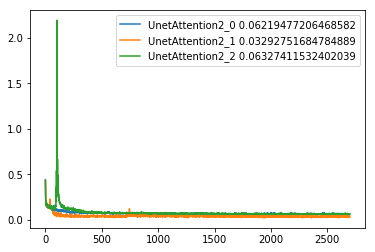

In [7]:
for i, (model, loss) in enumerate(losses):
    plt.plot(loss, label=model+"_{} {}".format(i, np.mean(loss[-100:])))
    
plt.legend()

In [8]:
data_path = 'YL1_UKM' 

paths = {
#     'lift': '02_NA-gr_output_lift1_fdnat.sgy',
    'lift': '03_NA-gr_output_lift2_agora_norm2.sgy',
    'raw': '01_NA-gr_input_prep_norm2.sgy',
}

base_path = os.path.join('/notebooks/data/', data_path)

In [9]:
losses = []
for i in range(3):
    loss = train_n_save(UnetAttention3, {**common_config, **unetatt2_new_config},
                        base_path, paths, model_path='./saved_models/{}/{}'.format(data_path, 'UnetAttention2'), n_epochs=5)
    losses.append(('UnetAttention2', loss))


100%|██████████| 4775/4775 [21:18<00:00,  3.71it/s]


./saved_models/YL1_UKM/UnetAttention2/2019-10-11_15:28:25.671905+03:00


100%|██████████| 4775/4775 [21:21<00:00,  3.72it/s]


./saved_models/YL1_UKM/UnetAttention2/2019-10-11_15:49:50.934352+03:00


100%|██████████| 4775/4775 [21:20<00:00,  3.73it/s]


./saved_models/YL1_UKM/UnetAttention2/2019-10-11_16:11:14.077027+03:00


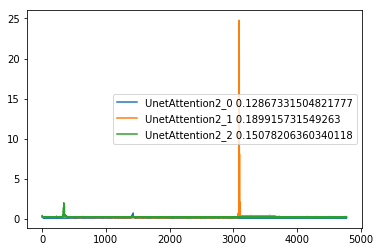

In [10]:
for i, (model, loss) in enumerate(losses):
    plt.plot(loss, label=model+"_{} {}".format(i, np.mean(loss[-100:])))
    
plt.legend()